In [1]:
import laser_lib
import numpy as np
import math
import time
#import cv2
#from skimage.color import rgb2lab, lab2rgb

In [2]:
queue = laser_lib.DacQueue()

Found  1 Helios DACs


In [3]:
import serial
import time

# --- CONFIGURABLE PARAMETERS ---

# ⚠️ IMPORTANT: Change this to your Arduino's serial port.
SERIAL_PORT = '/dev/ttyACM0' 

# This must match the baud rate in your Arduino script.
BAUD_RATE = 9600

# This must match the 'dataPoints' variable in your Arduino script.
NUM_POINTS_PER_BATCH = 100

# The reference voltage of your Arduino (usually 5.0V).
REFERENCE_VOLTAGE = 5.0

# --- END OF PARAMETERS ---


def get_arduino_batch(ser, num_points, ref_voltage):
    """
    Listens for and receives a single, complete batch of data from the Arduino.

    This function waits for the Arduino's "sending data" signal, then reads
    the specified number of data points, converts them to voltage, and
    returns them as a list of floats.

    Args:
        ser (serial.Serial): An active, open pyserial connection object.
        num_points (int): The number of data points to expect in the batch.
        ref_voltage (float): The Arduino's reference voltage for conversion.

    Returns:
        list: A list of floating-point voltage values, or None if an error occurs.
    """
    # # Wait until we receive the Arduino's signal that it's sending data.
    # while True:
    #     line = ser.readline().decode('utf-8').strip()
    #     if "Sending data to computer" in line:
    #         print(f"\nIncoming data batch detected at {time.strftime('%H:%M:%S')}...")
    #         break # Exit the waiting loop and proceed to read data.

    # Now, read the exact number of data points we expect.
    batch_data = []
    for _ in range(num_points):
        try:
            # Read the next line, which should be a number.
            data_line = ser.readline().decode('utf-8').strip()
            
            # Convert the raw integer string (0-1023) to a floating-point voltage.
            raw_value = int(data_line)
            voltage = (raw_value / 1023.0) * ref_voltage
            batch_data.append(voltage)
        
        except (ValueError, IndexError):
            # Handle cases where a line is not a valid number or is empty.
            print(f"⚠️ Warning: Could not parse a data point. Adding None as a placeholder.", data_line)
            batch_data.append(None)
            return None
            
    return batch_data


def main():
    """
    Main function to demonstrate repeatedly calling get_arduino_batch.
    """
    all_data = [] # A list to store all the batches we collect.
    
    try:
        # Establish the serial connection. The 'with' statement ensures it's closed properly.
        print(f"Attempting to connect to {SERIAL_PORT} at {BAUD_RATE} baud...")
        with serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=2) as ser:
            print(f"✅ Connection successful! Waiting for data...")
            
            # This loop will run forever, getting one batch at a time.
            while True:
                # Call the function to get the next batch.
                new_batch = get_arduino_batch(ser, NUM_POINTS_PER_BATCH, REFERENCE_VOLTAGE)
                
                if new_batch:
                    all_data.append(new_batch)
                    print(f"✅ Batch received. Total batches collected: {len(all_data)}")
                    # Print the first 5 values of the new batch as a preview
                    print(f"   Preview: {[f'{v:.2f}V' for v in new_batch[:5] if v is not None]}")

    except serial.SerialException as e:
        print(f"❌ Error: Could not open serial port '{SERIAL_PORT}'.")
        print("   Please check that the Arduino is plugged in and the port name is correct.")
    
    except KeyboardInterrupt:
        print("\n🛑 Program stopped by user.")
    
    finally:
        print(f"\nFinished with {len(all_data)} batches collected.")


# if __name__ == "__main__":
#     main()

In [4]:
# # Circle
# queue.dac_rate = 30000
# T = 500
# arr_pos = np.zeros((T, 2))
# arr_col = np.zeros((T, 3))
# arr_col[:, :] = 1
# theta = np.linspace(0, 2*np.pi, T)
# arr_pos[:, 0] = np.cos(theta)
# arr_pos[:, 1] = np.sin(theta)

# #arr_col = arr_col*np.expand_dims((theta > np.pi/2), 1)

# while(True):
#     queue.submit(arr_pos, arr_col)

In [49]:
# Sweep left to right
# Scan the scene and record after every line
xy_min = -0.4
xy_max = 0.4
num_lines = 10
lines_y = np.linspace(xy_max, xy_min, num_lines)
queue.dac_rate = 10000
T = 1000
arr_pos = np.zeros((T, 2))
arr_col = np.zeros((T, 3))
x = np.linspace(xy_max, xy_min, T//2)
arr_pos[:, 0] = np.concatenate([x, x[::-1]])
arr_col[:, 1] = np.concatenate([np.ones_like(x), np.zeros_like(x[::-1])])

while(True):
    for idx, y in enumerate(lines_y):
        arr_pos[:, 1] = y
        queue.submit(arr_pos, arr_col)

KeyboardInterrupt: 

In [50]:
# Scan the scene and record after every line
xy_min = -0.4
xy_max = 0.4
queue.dac_rate = 1000
T = 1000
T_rew = T//10
#T_rew = T
arr_pos = np.zeros((T, 2))
arr_pos_rew = np.zeros((T_rew, 2))
arr_col = np.ones((T, 3))
arr_col_rew = np.zeros((T_rew, 3))
x = np.linspace(xy_max, xy_min, T)
arr_pos[:, 0] = x
arr_pos_rew[:, 0] = np.linspace(xy_min, xy_max, T_rew)

num_lines = 100
samples_per_line = 10
lines_y = np.linspace(xy_max, xy_min, num_lines)
line_arr = []
with serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=2) as ser:
    print(f"✅ Connection successful! Waiting for data...")
    # while(True):
    for idx, y in enumerate(lines_y):
        samples_arr = []
        for sample in range(samples_per_line):
            print(sample, idx, end='\r')
            # Scan left to right
            arr_pos[:, 1] = y
            queue.submit(arr_pos, arr_col)
            # Rewind
            arr_pos_rew[:, 1] = y
            for i in range(1):
                queue.submit(arr_pos_rew, arr_col_rew)
            print('Getting batch: ')
            batch = get_arduino_batch(ser, 100, 5.0)
            samples_arr.append(batch)
            print('Batch: ', batch)
        line_arr.append(samples_arr)

✅ Connection successful! Waiting for data...
Getting batch: 
⚠️ Warning: Could not parse a data point. Adding None as a placeholder. 
Batch:  None
Getting batch: 
Batch:  [0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.1906158357771261, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342130987292, 0.19550342

In [51]:
smoothed = []
for idx, samples_arr in enumerate(line_arr):
    print('sample: ', idx, '/', len(line_arr))
    samples = [s for s in samples_arr if s]
    print(len(samples))
    if(len(samples) < 1):
        continue
    stack = np.stack(samples, axis=0)
    smooth = np.mean(stack, axis=0)
    print(stack.shape, smooth.shape)
    smoothed.append(smooth)
print('Done: ', len(smoothed), len(smoothed[0]))
img = np.stack(smoothed, axis=1)
print(img.shape)

sample:  0 / 100
8
(8, 100) (100,)
sample:  1 / 100
10
(10, 100) (100,)
sample:  2 / 100
10
(10, 100) (100,)
sample:  3 / 100
10
(10, 100) (100,)
sample:  4 / 100
10
(10, 100) (100,)
sample:  5 / 100
10
(10, 100) (100,)
sample:  6 / 100
10
(10, 100) (100,)
sample:  7 / 100
10
(10, 100) (100,)
sample:  8 / 100
10
(10, 100) (100,)
sample:  9 / 100
10
(10, 100) (100,)
sample:  10 / 100
10
(10, 100) (100,)
sample:  11 / 100
10
(10, 100) (100,)
sample:  12 / 100
10
(10, 100) (100,)
sample:  13 / 100
10
(10, 100) (100,)
sample:  14 / 100
10
(10, 100) (100,)
sample:  15 / 100
10
(10, 100) (100,)
sample:  16 / 100
10
(10, 100) (100,)
sample:  17 / 100
10
(10, 100) (100,)
sample:  18 / 100
10
(10, 100) (100,)
sample:  19 / 100
10
(10, 100) (100,)
sample:  20 / 100
10
(10, 100) (100,)
sample:  21 / 100
10
(10, 100) (100,)
sample:  22 / 100
10
(10, 100) (100,)
sample:  23 / 100
10
(10, 100) (100,)
sample:  24 / 100
10
(10, 100) (100,)
sample:  25 / 100
10
(10, 100) (100,)
sample:  26 / 100
10
(10

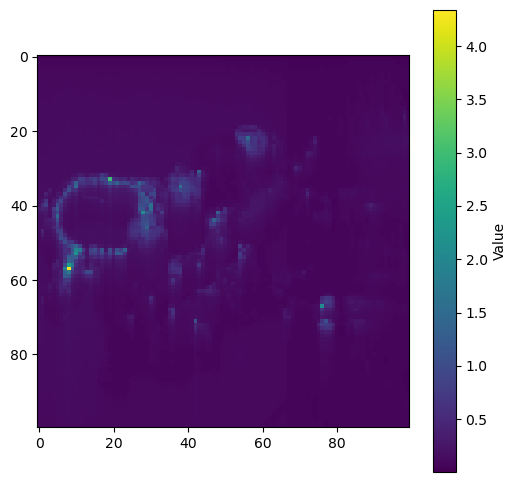

In [52]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='viridis') # Display the array as an image
plt.colorbar(label='Value')      # Add a colorbar to map values to colors
plt.show()